In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('talk')
sns.set_style("whitegrid")

# Filter Response

To characterize a filter we general want to know its

1. **amplitude frequency response**, and its
2. **phase response**.

If a filter sharply sets the a specific range of frequencies to zero and let the rest untouched it is called *brick wall*.
For example, we could compute the [Fourier transform](def-fourier-transform-exp) of a signal and then multiply frequency in that range with zero.
For computational complexity and buffering reasons, such ideal filters are rahter unpractical for real-time use.

```{admonition} Filtering and the Fourier transform
:name: remark-filtering-and-convolution
:class: remark

Filtering can be achieved by multiplication in the spectural domain and by convolution in the time domain.

```

Therefore, most filters work differently.
They reduce or strengthen the power of certain frequencies.

## Butterworth Filter

If we speak of filters, we often refer to *low pass* or *high pass filters*. 
They filter frequencies above or below some *cutoff frequency*.
For example, the low pass filter ``LPF`` in ``sclang`` is a *2nd order Butterworth lowpass filter*.

```{figure} ../../../figs/sounddesign/filters/butterworth-filter.png
---
width: 600px
name: fig-butterworth-filter
---
Effect of a first-order Butterworth lowpass filter. By Alejo2083 - Own work, CC BY-SA 3.0, [link](https://commons.wikimedia.org/w/index.php?curid=735081).
```

The filter reduces the gain (amplitude) for frequencies above the cutoff frequency and shifts their phases.
Well, that is not entirely true because the cutoff frequency is also reduced by 6 [decibel (dB)](sec-intensity), so the reduction starts a little bit below the cutoff frequency.
Reducing the loudness by 6 dB means that the perceived level is reduced by a factor of 4.
The top plot of {numref}`Fig. {number} <fig-butterworth-filter>` shows the reduction in amplitude.

The second effect of the filter is a phase shift; compare the bottom plot of {numref}`Fig. {number} <fig-butterworth-filter>`.
This effect is crucial if we combine multiple filters because they interact!
In other words: we can not just combine a high pass and low pass filter to get the same result as a band pass filter!

The following code is an example of a band pass filter.
First, we use a low pass and high pass filter; then a band pass filter.
The results sound very similar but not identical.

```isc
({
    var sig = LFSaw.ar(500) ! 2 * 0.5;
    sig = HPF.ar(sig, 200);
    sig = LPF.ar(sig, 300);
    sig
}.play;)

({
    var sig = LFSaw.ar(500) ! 2 * 0.5;
    var bandwidth = 100;
    var cuttoffFeq = 200;
    sig = BPF.ar(sig, 250, rq: bandwidth / cuttoffFeq);
    sig
}.play;)
```

For completeness I also want to mention the inverse filter of a band pass filter: the band reject filter ``BRF``.
The following example rejects frequencies between 200 and 300 Hz, i.e., the inverse operation as before.

```isc
({
    var sig = LFSaw.ar(500) ! 2 * 0.5;
    var bandwidth = 100;
    var cuttoffFeq = 200;
    sig = BRF.ar(sig, 250, rq: bandwidth / cuttoffFeq);
    sig
}.play;)
```

## Computation (Example)

Let us define some relevant terms and formulas such that we can characterize filters.
I will do so by example.
The *gain* $H(f)$ in frequency $f$ is equal to the frequency amplitude of the input signal divided by the frequency amplitude of the output signal:

\begin{equation}
G(f) = \frac{O(f)}{I(f)}
\end{equation}

Let $x[n]$ be an input signal, $y[n]$ the output signal of the filter and $f_s = \frac{1}{T}$ the sample rate.
Let use start with a very *simple filter*:

\begin{equation}
y[n] = x[n] + x[n-1], \quad n = 0, 1, 2, \ldots
\end{equation}

Note that $x[t]$ is defined for $t = n T$ with $n = 0, 1, 2, \ldots$

To analyse what effect the filter has on a specific frequency we define $x[n]$ to be a sinusoid containing one specific frequency $f$.
Therefore, we assume:

\begin{equation*}
x[n] = A \cdot e^{i(2\pi f n T + \phi)}.
\end{equation*}

Let us simplify by assuming $A = 1$, $\phi = 0$ and $\omega = 2\pi f$ thus

\begin{equation*}
x[n] = e^{i \omega n T}.
\end{equation*}

Therefore, $y[n]$ is defined by

\begin{equation*}
\begin{split}
y[n] &= e^{i \omega n T} + e^{i \omega (n-1) T}\\
&= e^{i \omega n T} + e^{i \omega n T} \cdot e^{-i \omega n T}\\
&= (1 + e^{-i \omega T}) \cdot e^{i \omega n T}\\
&= (1 + e^{-i \omega T}) \cdot x[n]
\end{split}
\end{equation*}

Therefore, the *gain* for this filter is

$$G(\omega) = |(1 + e^{-i \omega T})|$$

and the phase response is

$$\mathcal{\Theta}(\omega) = \angle 1 + e^{-i \omega T}.$$

```{admonition} Filter Response
:name: def-filter-response
:class: definition

The overall *filter response* can be represented in one formula (see section [Complex Numbers](sec-complex-numbers))

\begin{equation}
H(\omega) = \underbrace{G(\omega)}_{\text{Amplitude}} \cdot \underbrace{e^{-i \mathcal{\Theta}(\omega)}}_{\text{Phase}}.
\end{equation}

where $G(\omega)$ is the *amplutide frequency response* and $\mathcal{\Theta}(\omega)$ the *phase response* of the filter.

```

We can further manipulate the formula for the *gain* by the following:

\begin{equation*}
\begin{split}
1 + e^{-i \omega T} &= e^0 + e^{-i \omega T}\\
&= (e^{i\omega T / 2} + e^{-i \omega T / 2}) \cdot e^{-i \omega T / 2}
\end{split}
\end{equation*}

using 

$$\cos(\phi) = \frac{e^{i\phi} - e^{-i \phi} }{2}$$

we get

\begin{equation*}
\begin{split}
1 + e^{-i \omega T} &= 2 \cdot \cos(\omega T / 2) \cdot e^{-i \omega T / 2}
\end{split}
\end{equation*}

Thus

$$G(\omega) = |2 \cdot \cos(\omega T / 2) \cdot e^{-i \omega T / 2}| = 2|\cos(\omega T / 2)|.$$

Because of the [Nyquist–Shannon sampling theorem](theorem-sampling), we can assume that we only look at frequencies $f$ such that $-f_s/2 \leq f \leq +f_s / 2$ holds.
Therefore, the equation simplifies to

$$2\cos(\omega T / 2)$$

for $-\pi \leq \omega \leq \pi$.
The following plot shows the amplitude frequency response in $\omega$.

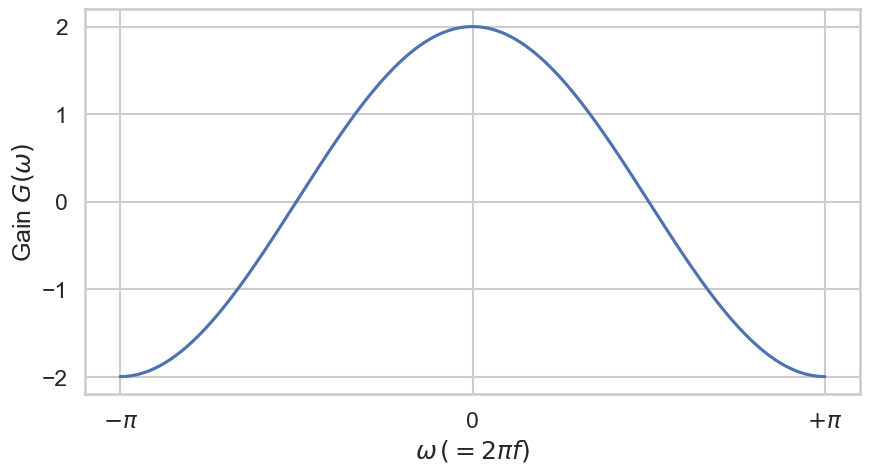

In [2]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x: 2 * np.cos(x)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, gain(t), label=r'$y(t)$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'$+\pi$'])
ax.set_ylabel(r'Gain $G(\omega)$')
ax.set_xlabel(r'$\omega\,(=2\pi f)$');

Secondly we look at the *phase response*

$$\mathcal{\Theta}(\omega) = -\frac{\omega T}{2}, \quad -\pi \leq \omega \leq \pi.$$

If we set $T = 1$ the plot looks like the following figure.

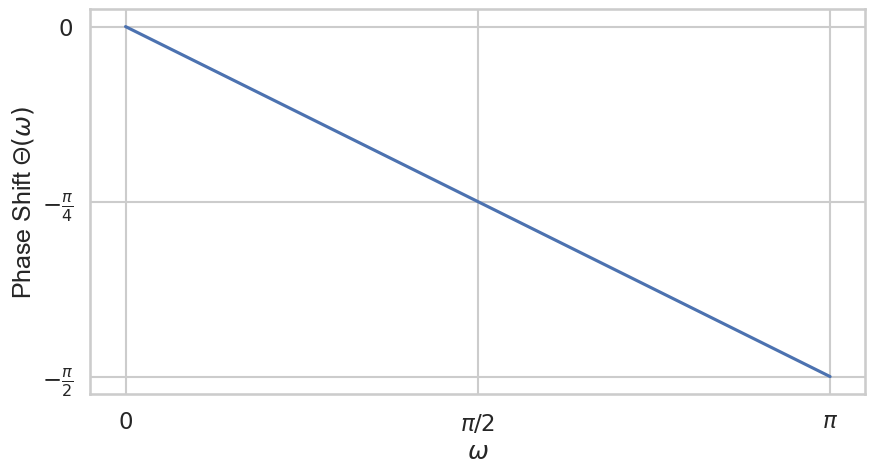

In [3]:
t = np.linspace(0, np.pi, 1000)
phase = lambda x: -x/2

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, phase(t), label=r'$y(t)$')
ax.set_xticks([0, np.pi/2, np.pi])
ax.set_yticks([-np.pi/2, -np.pi/4, 0])
ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$']);
ax.set_yticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$']);
ax.set_ylabel(r'Phase Shift $\mathcal{\Theta}(\omega)$')
ax.set_xlabel(r'$\omega$');

This *low pass filter* has no phase delay at 0 Hz and a maximum delay of $-(\pi/2)T$ at the Nyquist frequency.
Note that both responses rely on the sample rate $f_s = 1 / T$.
Furthermore, the phase shift depends on $\omega$.
It looks like this might lead to a phase distortion, however, this frequency-dependent delay is counteracted because doubling the frequency of the input halves its period, balancing the growth in retardation introduced by the filter.
This linear dependence is actually necessary.

```{admonition} Linear Phase Filters
:name: def-linear-phase-filter
:class: definition

If the phase response of the filter is a linear (straight-line) function of frequency (excluding phase wraps at $\pm 180$ degree), the filter is said to be *linear phase*.

```

Filters that are not linear phase can introduce *phase distortion*.